<a href="https://colab.research.google.com/github/gohzhihwee/stuffs/blob/main/transformer_findata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import os
import math
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler

In [2]:
def create_sequences(data, time_steps):
    X, y = [], []
    for x in range(len(data)-time_steps):
      X.append(data.iloc[x:x+time_steps,:].values)
      y.append(data.iloc[x+time_steps,:].values)
    return X, y

In [3]:
time_steps = 50
training_dataset = pd.read_csv("HKEX-06669.csv")
testing_dataset = pd.read_csv("HKEX-10276.csv")
testing_data = testing_dataset.iloc[:, [1,4,5,7,8,9,10,11]]
training_data = training_dataset.iloc[:len(testing_data), [1,4,5,7,8,9,10,11]]

def min_max_scaler(data):
    for col in data.columns:
      data[f'{col}'] = data[f'{col}']/data[f'{col}'].abs().max()
      data[f'{col}'] = data[f'{col}'].fillna(0)
    return data

training_data = min_max_scaler(training_data)
testing_data = min_max_scaler(testing_data)

# print(training_data)
# print(testing_data)


X_train, y_train = create_sequences(training_data, time_steps)
X_test, y_test = create_sequences(testing_data, time_steps)

X_train, y_train, X_test, y_test = np.array(X_train), np.array([y_train]), np.array(X_test), np.array([y_test])
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(89, 50, 8)
(1, 89, 8)
(89, 50, 8)
(1, 89, 8)


<ipython-input-3-bcc04bdf4bac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}'] = data[f'{col}']/data[f'{col}'].abs().max()
<ipython-input-3-bcc04bdf4bac>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'{col}'] = data[f'{col}'].fillna(0)


In [4]:
## Implementation taken from Theodoros Ntakouris (can be found on the Keras website)
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [5]:
def build_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    dropout=0,
    mlp_dropout=0,
):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    outputs = x
    return keras.Model(inputs, outputs)

In [6]:
input_shape = X_train.shape[1:]
input_shape_y = y_train.shape[1:]

model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

model_y = build_model(
    input_shape_y,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25,
)

mse = keras.losses.MeanSquaredError()

model.compile(
    loss=mse,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model.summary()

model_y.compile(
    loss=mse,
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=["mean_squared_error"],
)
model_y.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=40, restore_best_weights=True)]

history = model.fit(
    X_train,
    X_train,
    validation_split=0.25,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

history_y = model_y.fit(
    y_train,
    y_train,
    validation_split=0,
    epochs=200,
    batch_size=64,
    callbacks=callbacks,
)

model.evaluate(X_test, X_test, verbose=1)
model_y.evaluate(y_test, y_test, verbose=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 8)]      0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 50, 8)       16          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 50, 8)       35848       ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

1/1 [==============================] - 10s 10s/step - loss: 0.9263 - mean_squared_error: 0.9263
Epoch 2/200
1/1 [==============================] - ETA: 0s - loss: 0.8196 - mean_squared_error: 0.8196

1/1 [==============================] - 0s 73ms/step - loss: 0.8196 - mean_squared_error: 0.8196
Epoch 3/200
1/1 [==============================] - ETA: 0s - loss: 0.7517 - mean_squared_error: 0.7517

1/1 [==============================] - 0s 67ms/step - loss: 0.7517 - mean_squared_error: 0.7517
Epoch 4/200
1/1 [==============================] - ETA: 0s - loss: 0.5831 - mean_squared_error: 0.5831

1/1 [==============================] - 0s 63ms/step - loss: 0.5831 - mean_squared_error: 0.5831
Epoch 5/200
1/1 [==============================] - ETA: 0s - loss: 0.4884 - mean_squared_error: 0.4884

1/1 [==============================] - 0s 76ms/step - loss: 0.4884 - mean_squared_error: 0.4884
Epoch 6/200
1/1 [==============================] - ETA: 0s - loss: 0.3911 - mean_squared_error: 0.3911

1/1 [==============================] - 0s 64ms/step - loss: 0.3911 - mean_squared_error: 0.3911
Epoch 7/200
1/1 [==============================] - ETA: 0s - loss: 0.4389 - mean_squared_error: 0.4389

1/1 [==============================] - 0s 64ms/step - loss: 0.4389 - mean_squared_error: 0.4389
Epoch 8/200
1/1 [==============================] - ETA: 0s - loss: 0.3442 - mean_squared_error: 0.3442

1/1 [==============================] - 0s 67ms/step - loss: 0.3442 - mean_squared_error: 0.3442
Epoch 9/200
1/1 [==============================] - ETA: 0s - loss: 0.3739 - mean_squared_error: 0.3739

1/1 [==============================] - 0s 62ms/step - loss: 0.3739 - mean_squared_error: 0.3739
Epoch 10/200
1/1 [==============================] - ETA: 0s - loss: 0.3375 - mean_squared_error: 0.3375

1/1 [==============================] - 0s 61ms/step - loss: 0.3375 - mean_squared_error: 0.3375
Epoch 11/200
1/1 [==============================] - ETA: 0s - loss: 0.3378 - mean_squared_error: 0.3378

1/1 [==============================] - 0s 71ms/step - loss: 0.3378 - mean_squared_error: 0.3378
Epoch 12/200
1/1 [==============================] - ETA: 0s - loss: 0.3649 - mean_squared_error: 0.3649

1/1 [==============================] - 0s 60ms/step - loss: 0.3649 - mean_squared_error: 0.3649
Epoch 13/200
1/1 [==============================] - ETA: 0s - loss: 0.3187 - mean_squared_error: 0.3187

1/1 [==============================] - 0s 62ms/step - loss: 0.3187 - mean_squared_error: 0.3187
Epoch 14/200
1/1 [==============================] - ETA: 0s - loss: 0.2995 - mean_squared_error: 0.2995

1/1 [==============================] - 0s 65ms/step - loss: 0.2995 - mean_squared_error: 0.2995
Epoch 15/200
1/1 [==============================] - ETA: 0s - loss: 0.3699 - mean_squared_error: 0.3699

1/1 [==============================] - 0s 62ms/step - loss: 0.3699 - mean_squared_error: 0.3699
Epoch 16/200
1/1 [==============================] - ETA: 0s - loss: 0.2971 - mean_squared_error: 0.2971

1/1 [==============================] - 0s 78ms/step - loss: 0.2971 - mean_squared_error: 0.2971
Epoch 17/200
1/1 [==============================] - ETA: 0s - loss: 0.2811 - mean_squared_error: 0.2811

1/1 [==============================] - 0s 67ms/step - loss: 0.2811 - mean_squared_error: 0.2811
Epoch 18/200
1/1 [==============================] - ETA: 0s - loss: 0.2879 - mean_squared_error: 0.2879

1/1 [==============================] - 0s 62ms/step - loss: 0.2879 - mean_squared_error: 0.2879
Epoch 19/200
1/1 [==============================] - ETA: 0s - loss: 0.2605 - mean_squared_error: 0.2605

1/1 [==============================] - 0s 73ms/step - loss: 0.2605 - mean_squared_error: 0.2605
Epoch 20/200
1/1 [==============================] - ETA: 0s - loss: 0.2734 - mean_squared_error: 0.2734

1/1 [==============================] - 0s 62ms/step - loss: 0.2734 - mean_squared_error: 0.2734
Epoch 21/200
1/1 [==============================] - ETA: 0s - loss: 0.2396 - mean_squared_error: 0.2396

1/1 [==============================] - 0s 73ms/step - loss: 0.2396 - mean_squared_error: 0.2396
Epoch 22/200
1/1 [==============================] - ETA: 0s - loss: 0.2207 - mean_squared_error: 0.2207

1/1 [==============================] - 0s 63ms/step - loss: 0.2207 - mean_squared_error: 0.2207
Epoch 23/200
1/1 [==============================] - ETA: 0s - loss: 0.2431 - mean_squared_error: 0.2431

1/1 [==============================] - 0s 61ms/step - loss: 0.2431 - mean_squared_error: 0.2431
Epoch 24/200
1/1 [==============================] - ETA: 0s - loss: 0.2451 - mean_squared_error: 0.2451

1/1 [==============================] - 0s 65ms/step - loss: 0.2451 - mean_squared_error: 0.2451
Epoch 25/200
1/1 [==============================] - ETA: 0s - loss: 0.2794 - mean_squared_error: 0.2794

1/1 [==============================] - 0s 59ms/step - loss: 0.2794 - mean_squared_error: 0.2794
Epoch 26/200
1/1 [==============================] - ETA: 0s - loss: 0.2617 - mean_squared_error: 0.2617

1/1 [==============================] - 0s 62ms/step - loss: 0.2617 - mean_squared_error: 0.2617
Epoch 27/200
1/1 [==============================] - ETA: 0s - loss: 0.2262 - mean_squared_error: 0.2262

1/1 [==============================] - 0s 67ms/step - loss: 0.2262 - mean_squared_error: 0.2262
Epoch 28/200
1/1 [==============================] - ETA: 0s - loss: 0.2358 - mean_squared_error: 0.2358

1/1 [==============================] - 0s 60ms/step - loss: 0.2358 - mean_squared_error: 0.2358
Epoch 29/200
1/1 [==============================] - ETA: 0s - loss: 0.2315 - mean_squared_error: 0.2315

1/1 [==============================] - 0s 61ms/step - loss: 0.2315 - mean_squared_error: 0.2315
Epoch 30/200
1/1 [==============================] - ETA: 0s - loss: 0.2094 - mean_squared_error: 0.2094

1/1 [==============================] - 0s 76ms/step - loss: 0.2094 - mean_squared_error: 0.2094
Epoch 31/200
1/1 [==============================] - ETA: 0s - loss: 0.2142 - mean_squared_error: 0.2142

1/1 [==============================] - 0s 86ms/step - loss: 0.2142 - mean_squared_error: 0.2142
Epoch 32/200
1/1 [==============================] - ETA: 0s - loss: 0.1932 - mean_squared_error: 0.1932

1/1 [==============================] - 0s 70ms/step - loss: 0.1932 - mean_squared_error: 0.1932
Epoch 33/200
1/1 [==============================] - ETA: 0s - loss: 0.2240 - mean_squared_error: 0.2240

1/1 [==============================] - 0s 63ms/step - loss: 0.2240 - mean_squared_error: 0.2240
Epoch 34/200
1/1 [==============================] - ETA: 0s - loss: 0.2298 - mean_squared_error: 0.2298

1/1 [==============================] - 0s 60ms/step - loss: 0.2298 - mean_squared_error: 0.2298
Epoch 35/200
1/1 [==============================] - ETA: 0s - loss: 0.2137 - mean_squared_error: 0.2137

1/1 [==============================] - 0s 66ms/step - loss: 0.2137 - mean_squared_error: 0.2137
Epoch 36/200
1/1 [==============================] - ETA: 0s - loss: 0.2123 - mean_squared_error: 0.2123

1/1 [==============================] - 0s 62ms/step - loss: 0.2123 - mean_squared_error: 0.2123
Epoch 37/200
1/1 [==============================] - ETA: 0s - loss: 0.1691 - mean_squared_error: 0.1691

1/1 [==============================] - 0s 60ms/step - loss: 0.1691 - mean_squared_error: 0.1691
Epoch 38/200
1/1 [==============================] - ETA: 0s - loss: 0.2399 - mean_squared_error: 0.2399

1/1 [==============================] - 0s 76ms/step - loss: 0.2399 - mean_squared_error: 0.2399
Epoch 39/200
1/1 [==============================] - ETA: 0s - loss: 0.2344 - mean_squared_error: 0.2344

1/1 [==============================] - 0s 65ms/step - loss: 0.2344 - mean_squared_error: 0.2344
Epoch 40/200
1/1 [==============================] - ETA: 0s - loss: 0.2004 - mean_squared_error: 0.2004

1/1 [==============================] - 0s 65ms/step - loss: 0.2004 - mean_squared_error: 0.2004
Epoch 41/200
1/1 [==============================] - ETA: 0s - loss: 0.1990 - mean_squared_error: 0.1990

1/1 [==============================] - 0s 64ms/step - loss: 0.1990 - mean_squared_error: 0.1990
Epoch 42/200
1/1 [==============================] - ETA: 0s - loss: 0.2496 - mean_squared_error: 0.2496

1/1 [==============================] - 0s 76ms/step - loss: 0.2496 - mean_squared_error: 0.2496
Epoch 43/200
1/1 [==============================] - ETA: 0s - loss: 0.1631 - mean_squared_error: 0.1631

1/1 [==============================] - 0s 65ms/step - loss: 0.1631 - mean_squared_error: 0.1631
Epoch 44/200
1/1 [==============================] - ETA: 0s - loss: 0.1809 - mean_squared_error: 0.1809

1/1 [==============================] - 0s 72ms/step - loss: 0.1809 - mean_squared_error: 0.1809
Epoch 45/200
1/1 [==============================] - ETA: 0s - loss: 0.1868 - mean_squared_error: 0.1868

1/1 [==============================] - 0s 67ms/step - loss: 0.1868 - mean_squared_error: 0.1868
Epoch 46/200
1/1 [==============================] - ETA: 0s - loss: 0.1790 - mean_squared_error: 0.1790

1/1 [==============================] - 0s 71ms/step - loss: 0.1790 - mean_squared_error: 0.1790
Epoch 47/200
1/1 [==============================] - ETA: 0s - loss: 0.1670 - mean_squared_error: 0.1670

1/1 [==============================] - 0s 62ms/step - loss: 0.1670 - mean_squared_error: 0.1670
Epoch 48/200
1/1 [==============================] - ETA: 0s - loss: 0.2024 - mean_squared_error: 0.2024

1/1 [==============================] - 0s 64ms/step - loss: 0.2024 - mean_squared_error: 0.2024
Epoch 49/200
1/1 [==============================] - ETA: 0s - loss: 0.1909 - mean_squared_error: 0.1909

1/1 [==============================] - 0s 77ms/step - loss: 0.1909 - mean_squared_error: 0.1909
Epoch 50/200
1/1 [==============================] - ETA: 0s - loss: 0.1940 - mean_squared_error: 0.1940

1/1 [==============================] - 0s 61ms/step - loss: 0.1940 - mean_squared_error: 0.1940
Epoch 51/200
1/1 [==============================] - ETA: 0s - loss: 0.1723 - mean_squared_error: 0.1723

1/1 [==============================] - 0s 69ms/step - loss: 0.1723 - mean_squared_error: 0.1723
Epoch 52/200
1/1 [==============================] - ETA: 0s - loss: 0.1671 - mean_squared_error: 0.1671

1/1 [==============================] - 0s 72ms/step - loss: 0.1671 - mean_squared_error: 0.1671
Epoch 53/200
1/1 [==============================] - ETA: 0s - loss: 0.1891 - mean_squared_error: 0.1891

1/1 [==============================] - 0s 77ms/step - loss: 0.1891 - mean_squared_error: 0.1891
Epoch 54/200
1/1 [==============================] - ETA: 0s - loss: 0.1586 - mean_squared_error: 0.1586

1/1 [==============================] - 0s 69ms/step - loss: 0.1586 - mean_squared_error: 0.1586
Epoch 55/200
1/1 [==============================] - ETA: 0s - loss: 0.1616 - mean_squared_error: 0.1616

1/1 [==============================] - 0s 61ms/step - loss: 0.1616 - mean_squared_error: 0.1616
Epoch 56/200
1/1 [==============================] - ETA: 0s - loss: 0.1632 - mean_squared_error: 0.1632

1/1 [==============================] - 0s 71ms/step - loss: 0.1632 - mean_squared_error: 0.1632
Epoch 57/200
1/1 [==============================] - ETA: 0s - loss: 0.1763 - mean_squared_error: 0.1763

1/1 [==============================] - 0s 89ms/step - loss: 0.1763 - mean_squared_error: 0.1763
Epoch 58/200
1/1 [==============================] - ETA: 0s - loss: 0.1445 - mean_squared_error: 0.1445

1/1 [==============================] - 0s 70ms/step - loss: 0.1445 - mean_squared_error: 0.1445
Epoch 59/200
1/1 [==============================] - ETA: 0s - loss: 0.1759 - mean_squared_error: 0.1759

1/1 [==============================] - 0s 67ms/step - loss: 0.1759 - mean_squared_error: 0.1759
Epoch 60/200
1/1 [==============================] - ETA: 0s - loss: 0.1735 - mean_squared_error: 0.1735

1/1 [==============================] - 0s 70ms/step - loss: 0.1735 - mean_squared_error: 0.1735
Epoch 61/200
1/1 [==============================] - ETA: 0s - loss: 0.1758 - mean_squared_error: 0.1758

1/1 [==============================] - 0s 67ms/step - loss: 0.1758 - mean_squared_error: 0.1758
Epoch 62/200
1/1 [==============================] - ETA: 0s - loss: 0.1882 - mean_squared_error: 0.1882

1/1 [==============================] - 0s 70ms/step - loss: 0.1882 - mean_squared_error: 0.1882
Epoch 63/200
1/1 [==============================] - ETA: 0s - loss: 0.1596 - mean_squared_error: 0.1596

1/1 [==============================] - 0s 67ms/step - loss: 0.1596 - mean_squared_error: 0.1596
Epoch 64/200
1/1 [==============================] - ETA: 0s - loss: 0.1607 - mean_squared_error: 0.1607

1/1 [==============================] - 0s 67ms/step - loss: 0.1607 - mean_squared_error: 0.1607
Epoch 65/200
1/1 [==============================] - ETA: 0s - loss: 0.1566 - mean_squared_error: 0.1566

1/1 [==============================] - 0s 63ms/step - loss: 0.1566 - mean_squared_error: 0.1566
Epoch 66/200
1/1 [==============================] - ETA: 0s - loss: 0.1672 - mean_squared_error: 0.1672

1/1 [==============================] - 0s 74ms/step - loss: 0.1672 - mean_squared_error: 0.1672
Epoch 67/200
1/1 [==============================] - ETA: 0s - loss: 0.1641 - mean_squared_error: 0.1641

1/1 [==============================] - 0s 71ms/step - loss: 0.1641 - mean_squared_error: 0.1641
Epoch 68/200
1/1 [==============================] - ETA: 0s - loss: 0.2053 - mean_squared_error: 0.2053

1/1 [==============================] - 0s 62ms/step - loss: 0.2053 - mean_squared_error: 0.2053
Epoch 69/200
1/1 [==============================] - ETA: 0s - loss: 0.1576 - mean_squared_error: 0.1576

1/1 [==============================] - 0s 79ms/step - loss: 0.1576 - mean_squared_error: 0.1576
Epoch 70/200
1/1 [==============================] - ETA: 0s - loss: 0.1891 - mean_squared_error: 0.1891

1/1 [==============================] - 0s 70ms/step - loss: 0.1891 - mean_squared_error: 0.1891
Epoch 71/200
1/1 [==============================] - ETA: 0s - loss: 0.1803 - mean_squared_error: 0.1803

1/1 [==============================] - 0s 75ms/step - loss: 0.1803 - mean_squared_error: 0.1803
Epoch 72/200
1/1 [==============================] - ETA: 0s - loss: 0.1625 - mean_squared_error: 0.1625

1/1 [==============================] - 0s 62ms/step - loss: 0.1625 - mean_squared_error: 0.1625
Epoch 73/200
1/1 [==============================] - ETA: 0s - loss: 0.1979 - mean_squared_error: 0.1979

1/1 [==============================] - 0s 66ms/step - loss: 0.1979 - mean_squared_error: 0.1979
Epoch 74/200
1/1 [==============================] - ETA: 0s - loss: 0.1796 - mean_squared_error: 0.1796

1/1 [==============================] - 0s 68ms/step - loss: 0.1796 - mean_squared_error: 0.1796
Epoch 75/200
1/1 [==============================] - ETA: 0s - loss: 0.2258 - mean_squared_error: 0.2258

1/1 [==============================] - 0s 63ms/step - loss: 0.2258 - mean_squared_error: 0.2258
Epoch 76/200
1/1 [==============================] - ETA: 0s - loss: 0.1533 - mean_squared_error: 0.1533

1/1 [==============================] - 0s 79ms/step - loss: 0.1533 - mean_squared_error: 0.1533
Epoch 77/200
1/1 [==============================] - ETA: 0s - loss: 0.1438 - mean_squared_error: 0.1438

1/1 [==============================] - 0s 65ms/step - loss: 0.1438 - mean_squared_error: 0.1438
Epoch 78/200
1/1 [==============================] - ETA: 0s - loss: 0.1493 - mean_squared_error: 0.1493

1/1 [==============================] - 0s 65ms/step - loss: 0.1493 - mean_squared_error: 0.1493
Epoch 79/200
1/1 [==============================] - ETA: 0s - loss: 0.1461 - mean_squared_error: 0.1461

1/1 [==============================] - 0s 71ms/step - loss: 0.1461 - mean_squared_error: 0.1461
Epoch 80/200
1/1 [==============================] - ETA: 0s - loss: 0.1909 - mean_squared_error: 0.1909

1/1 [==============================] - 0s 75ms/step - loss: 0.1909 - mean_squared_error: 0.1909
Epoch 81/200
1/1 [==============================] - ETA: 0s - loss: 0.1609 - mean_squared_error: 0.1609

1/1 [==============================] - 0s 73ms/step - loss: 0.1609 - mean_squared_error: 0.1609
Epoch 82/200
1/1 [==============================] - ETA: 0s - loss: 0.1483 - mean_squared_error: 0.1483

1/1 [==============================] - 0s 76ms/step - loss: 0.1483 - mean_squared_error: 0.1483
Epoch 83/200
1/1 [==============================] - ETA: 0s - loss: 0.2085 - mean_squared_error: 0.2085

1/1 [==============================] - 0s 69ms/step - loss: 0.2085 - mean_squared_error: 0.2085
Epoch 84/200
1/1 [==============================] - ETA: 0s - loss: 0.1475 - mean_squared_error: 0.1475

1/1 [==============================] - 0s 79ms/step - loss: 0.1475 - mean_squared_error: 0.1475
Epoch 85/200
1/1 [==============================] - ETA: 0s - loss: 0.1718 - mean_squared_error: 0.1718

1/1 [==============================] - 0s 70ms/step - loss: 0.1718 - mean_squared_error: 0.1718
Epoch 86/200
1/1 [==============================] - ETA: 0s - loss: 0.1455 - mean_squared_error: 0.1455

1/1 [==============================] - 0s 66ms/step - loss: 0.1455 - mean_squared_error: 0.1455
Epoch 87/200
1/1 [==============================] - ETA: 0s - loss: 0.1289 - mean_squared_error: 0.1289

1/1 [==============================] - 0s 66ms/step - loss: 0.1289 - mean_squared_error: 0.1289
Epoch 88/200
1/1 [==============================] - ETA: 0s - loss: 0.1484 - mean_squared_error: 0.1484

1/1 [==============================] - 0s 75ms/step - loss: 0.1484 - mean_squared_error: 0.1484
Epoch 89/200
1/1 [==============================] - ETA: 0s - loss: 0.1842 - mean_squared_error: 0.1842

1/1 [==============================] - 0s 72ms/step - loss: 0.1842 - mean_squared_error: 0.1842
Epoch 90/200
1/1 [==============================] - ETA: 0s - loss: 0.1530 - mean_squared_error: 0.1530

1/1 [==============================] - 0s 66ms/step - loss: 0.1530 - mean_squared_error: 0.1530
Epoch 91/200
1/1 [==============================] - ETA: 0s - loss: 0.1500 - mean_squared_error: 0.1500

1/1 [==============================] - 0s 68ms/step - loss: 0.1500 - mean_squared_error: 0.1500
Epoch 92/200
1/1 [==============================] - ETA: 0s - loss: 0.2027 - mean_squared_error: 0.2027

1/1 [==============================] - 0s 74ms/step - loss: 0.2027 - mean_squared_error: 0.2027
Epoch 93/200
1/1 [==============================] - ETA: 0s - loss: 0.1628 - mean_squared_error: 0.1628

1/1 [==============================] - 0s 72ms/step - loss: 0.1628 - mean_squared_error: 0.1628
Epoch 94/200
1/1 [==============================] - ETA: 0s - loss: 0.1557 - mean_squared_error: 0.1557

1/1 [==============================] - 0s 63ms/step - loss: 0.1557 - mean_squared_error: 0.1557
Epoch 95/200
1/1 [==============================] - ETA: 0s - loss: 0.1427 - mean_squared_error: 0.1427

1/1 [==============================] - 0s 70ms/step - loss: 0.1427 - mean_squared_error: 0.1427
Epoch 96/200
1/1 [==============================] - ETA: 0s - loss: 0.1622 - mean_squared_error: 0.1622

1/1 [==============================] - 0s 72ms/step - loss: 0.1622 - mean_squared_error: 0.1622
Epoch 97/200
1/1 [==============================] - ETA: 0s - loss: 0.1657 - mean_squared_error: 0.1657

1/1 [==============================] - 0s 80ms/step - loss: 0.1657 - mean_squared_error: 0.1657
Epoch 98/200
1/1 [==============================] - ETA: 0s - loss: 0.1394 - mean_squared_error: 0.1394

1/1 [==============================] - 0s 67ms/step - loss: 0.1394 - mean_squared_error: 0.1394
Epoch 99/200
1/1 [==============================] - ETA: 0s - loss: 0.1339 - mean_squared_error: 0.1339

1/1 [==============================] - 0s 69ms/step - loss: 0.1339 - mean_squared_error: 0.1339
Epoch 100/200
1/1 [==============================] - ETA: 0s - loss: 0.1379 - mean_squared_error: 0.1379

1/1 [==============================] - 0s 65ms/step - loss: 0.1379 - mean_squared_error: 0.1379
Epoch 101/200
1/1 [==============================] - ETA: 0s - loss: 0.1443 - mean_squared_error: 0.1443

1/1 [==============================] - 0s 81ms/step - loss: 0.1443 - mean_squared_error: 0.1443
Epoch 102/200
1/1 [==============================] - ETA: 0s - loss: 0.1686 - mean_squared_error: 0.1686

1/1 [==============================] - 0s 65ms/step - loss: 0.1686 - mean_squared_error: 0.1686
Epoch 103/200
1/1 [==============================] - ETA: 0s - loss: 0.1343 - mean_squared_error: 0.1343

1/1 [==============================] - 0s 68ms/step - loss: 0.1343 - mean_squared_error: 0.1343
Epoch 104/200
1/1 [==============================] - ETA: 0s - loss: 0.1310 - mean_squared_error: 0.1310

1/1 [==============================] - 0s 71ms/step - loss: 0.1310 - mean_squared_error: 0.1310
Epoch 105/200
1/1 [==============================] - ETA: 0s - loss: 0.1629 - mean_squared_error: 0.1629

1/1 [==============================] - 0s 80ms/step - loss: 0.1629 - mean_squared_error: 0.1629
Epoch 106/200
1/1 [==============================] - ETA: 0s - loss: 0.1449 - mean_squared_error: 0.1449

1/1 [==============================] - 0s 65ms/step - loss: 0.1449 - mean_squared_error: 0.1449
Epoch 107/200
1/1 [==============================] - ETA: 0s - loss: 0.2002 - mean_squared_error: 0.2002

1/1 [==============================] - 0s 66ms/step - loss: 0.2002 - mean_squared_error: 0.2002
Epoch 108/200
1/1 [==============================] - ETA: 0s - loss: 0.1338 - mean_squared_error: 0.1338

1/1 [==============================] - 0s 76ms/step - loss: 0.1338 - mean_squared_error: 0.1338
Epoch 109/200
1/1 [==============================] - ETA: 0s - loss: 0.1476 - mean_squared_error: 0.1476

1/1 [==============================] - 0s 68ms/step - loss: 0.1476 - mean_squared_error: 0.1476
Epoch 110/200
1/1 [==============================] - ETA: 0s - loss: 0.1289 - mean_squared_error: 0.1289

1/1 [==============================] - 0s 84ms/step - loss: 0.1289 - mean_squared_error: 0.1289
Epoch 111/200
1/1 [==============================] - ETA: 0s - loss: 0.1251 - mean_squared_error: 0.1251

1/1 [==============================] - 0s 65ms/step - loss: 0.1251 - mean_squared_error: 0.1251
Epoch 112/200
1/1 [==============================] - ETA: 0s - loss: 0.1673 - mean_squared_error: 0.1673

1/1 [==============================] - 0s 79ms/step - loss: 0.1673 - mean_squared_error: 0.1673
Epoch 113/200
1/1 [==============================] - ETA: 0s - loss: 0.1531 - mean_squared_error: 0.1531

1/1 [==============================] - 0s 66ms/step - loss: 0.1531 - mean_squared_error: 0.1531
Epoch 114/200
1/1 [==============================] - ETA: 0s - loss: 0.1684 - mean_squared_error: 0.1684

1/1 [==============================] - 0s 62ms/step - loss: 0.1684 - mean_squared_error: 0.1684
Epoch 115/200
1/1 [==============================] - ETA: 0s - loss: 0.1513 - mean_squared_error: 0.1513

1/1 [==============================] - 0s 75ms/step - loss: 0.1513 - mean_squared_error: 0.1513
Epoch 116/200
1/1 [==============================] - ETA: 0s - loss: 0.1431 - mean_squared_error: 0.1431

1/1 [==============================] - 0s 76ms/step - loss: 0.1431 - mean_squared_error: 0.1431
Epoch 117/200
1/1 [==============================] - ETA: 0s - loss: 0.1613 - mean_squared_error: 0.1613

1/1 [==============================] - 0s 69ms/step - loss: 0.1613 - mean_squared_error: 0.1613
Epoch 118/200
1/1 [==============================] - ETA: 0s - loss: 0.1448 - mean_squared_error: 0.1448

1/1 [==============================] - 0s 64ms/step - loss: 0.1448 - mean_squared_error: 0.1448
Epoch 119/200
1/1 [==============================] - ETA: 0s - loss: 0.1370 - mean_squared_error: 0.1370

1/1 [==============================] - 0s 67ms/step - loss: 0.1370 - mean_squared_error: 0.1370
Epoch 120/200
1/1 [==============================] - ETA: 0s - loss: 0.1607 - mean_squared_error: 0.1607

1/1 [==============================] - 0s 82ms/step - loss: 0.1607 - mean_squared_error: 0.1607
Epoch 121/200
1/1 [==============================] - ETA: 0s - loss: 0.1506 - mean_squared_error: 0.1506

1/1 [==============================] - 0s 62ms/step - loss: 0.1506 - mean_squared_error: 0.1506
Epoch 122/200
1/1 [==============================] - ETA: 0s - loss: 0.1444 - mean_squared_error: 0.1444

1/1 [==============================] - 0s 70ms/step - loss: 0.1444 - mean_squared_error: 0.1444
Epoch 123/200
1/1 [==============================] - ETA: 0s - loss: 0.1786 - mean_squared_error: 0.1786

1/1 [==============================] - 0s 80ms/step - loss: 0.1786 - mean_squared_error: 0.1786
Epoch 124/200
1/1 [==============================] - ETA: 0s - loss: 0.1551 - mean_squared_error: 0.1551

1/1 [==============================] - 0s 72ms/step - loss: 0.1551 - mean_squared_error: 0.1551
Epoch 125/200
1/1 [==============================] - ETA: 0s - loss: 0.1423 - mean_squared_error: 0.1423

1/1 [==============================] - 0s 74ms/step - loss: 0.1423 - mean_squared_error: 0.1423
Epoch 126/200
1/1 [==============================] - ETA: 0s - loss: 0.1455 - mean_squared_error: 0.1455

1/1 [==============================] - 0s 68ms/step - loss: 0.1455 - mean_squared_error: 0.1455
Epoch 127/200
1/1 [==============================] - ETA: 0s - loss: 0.1431 - mean_squared_error: 0.1431

1/1 [==============================] - 0s 65ms/step - loss: 0.1431 - mean_squared_error: 0.1431
Epoch 128/200
1/1 [==============================] - ETA: 0s - loss: 0.1589 - mean_squared_error: 0.1589

1/1 [==============================] - 0s 61ms/step - loss: 0.1589 - mean_squared_error: 0.1589
Epoch 129/200
1/1 [==============================] - ETA: 0s - loss: 0.1521 - mean_squared_error: 0.1521

1/1 [==============================] - 0s 77ms/step - loss: 0.1521 - mean_squared_error: 0.1521
Epoch 130/200
1/1 [==============================] - ETA: 0s - loss: 0.1640 - mean_squared_error: 0.1640

1/1 [==============================] - 0s 118ms/step - loss: 0.1640 - mean_squared_error: 0.1640
Epoch 131/200
1/1 [==============================] - ETA: 0s - loss: 0.1452 - mean_squared_error: 0.1452

1/1 [==============================] - 0s 120ms/step - loss: 0.1452 - mean_squared_error: 0.1452
Epoch 132/200
1/1 [==============================] - ETA: 0s - loss: 0.1336 - mean_squared_error: 0.1336

1/1 [==============================] - 0s 128ms/step - loss: 0.1336 - mean_squared_error: 0.1336
Epoch 133/200
1/1 [==============================] - ETA: 0s - loss: 0.1662 - mean_squared_error: 0.1662

1/1 [==============================] - 0s 124ms/step - loss: 0.1662 - mean_squared_error: 0.1662
Epoch 134/200
1/1 [==============================] - ETA: 0s - loss: 0.1271 - mean_squared_error: 0.1271

1/1 [==============================] - 0s 119ms/step - loss: 0.1271 - mean_squared_error: 0.1271
Epoch 135/200
1/1 [==============================] - ETA: 0s - loss: 0.1322 - mean_squared_error: 0.1322

1/1 [==============================] - 0s 108ms/step - loss: 0.1322 - mean_squared_error: 0.1322
Epoch 136/200
1/1 [==============================] - ETA: 0s - loss: 0.1491 - mean_squared_error: 0.1491

1/1 [==============================] - 0s 104ms/step - loss: 0.1491 - mean_squared_error: 0.1491
Epoch 137/200
1/1 [==============================] - ETA: 0s - loss: 0.2101 - mean_squared_error: 0.2101

1/1 [==============================] - 0s 115ms/step - loss: 0.2101 - mean_squared_error: 0.2101
Epoch 138/200
1/1 [==============================] - ETA: 0s - loss: 0.1571 - mean_squared_error: 0.1571

1/1 [==============================] - 0s 115ms/step - loss: 0.1571 - mean_squared_error: 0.1571
Epoch 139/200
1/1 [==============================] - ETA: 0s - loss: 0.1622 - mean_squared_error: 0.1622

1/1 [==============================] - 0s 115ms/step - loss: 0.1622 - mean_squared_error: 0.1622
Epoch 140/200
1/1 [==============================] - ETA: 0s - loss: 0.1551 - mean_squared_error: 0.1551

1/1 [==============================] - 0s 110ms/step - loss: 0.1551 - mean_squared_error: 0.1551
Epoch 141/200
1/1 [==============================] - ETA: 0s - loss: 0.1196 - mean_squared_error: 0.1196

1/1 [==============================] - 0s 117ms/step - loss: 0.1196 - mean_squared_error: 0.1196
Epoch 142/200
1/1 [==============================] - ETA: 0s - loss: 0.1425 - mean_squared_error: 0.1425

1/1 [==============================] - 0s 115ms/step - loss: 0.1425 - mean_squared_error: 0.1425
Epoch 143/200
1/1 [==============================] - ETA: 0s - loss: 0.1520 - mean_squared_error: 0.1520

1/1 [==============================] - 0s 99ms/step - loss: 0.1520 - mean_squared_error: 0.1520
Epoch 144/200
1/1 [==============================] - ETA: 0s - loss: 0.1348 - mean_squared_error: 0.1348

1/1 [==============================] - 0s 98ms/step - loss: 0.1348 - mean_squared_error: 0.1348
Epoch 145/200
1/1 [==============================] - ETA: 0s - loss: 0.1280 - mean_squared_error: 0.1280

1/1 [==============================] - 0s 103ms/step - loss: 0.1280 - mean_squared_error: 0.1280
Epoch 146/200
1/1 [==============================] - ETA: 0s - loss: 0.1128 - mean_squared_error: 0.1128

1/1 [==============================] - 0s 96ms/step - loss: 0.1128 - mean_squared_error: 0.1128
Epoch 147/200
1/1 [==============================] - ETA: 0s - loss: 0.1352 - mean_squared_error: 0.1352

1/1 [==============================] - 0s 98ms/step - loss: 0.1352 - mean_squared_error: 0.1352
Epoch 148/200
1/1 [==============================] - ETA: 0s - loss: 0.1672 - mean_squared_error: 0.1672

1/1 [==============================] - 0s 127ms/step - loss: 0.1672 - mean_squared_error: 0.1672
Epoch 149/200
1/1 [==============================] - ETA: 0s - loss: 0.1588 - mean_squared_error: 0.1588

1/1 [==============================] - 0s 104ms/step - loss: 0.1588 - mean_squared_error: 0.1588
Epoch 150/200
1/1 [==============================] - ETA: 0s - loss: 0.1291 - mean_squared_error: 0.1291

1/1 [==============================] - 0s 119ms/step - loss: 0.1291 - mean_squared_error: 0.1291
Epoch 151/200
1/1 [==============================] - ETA: 0s - loss: 0.1416 - mean_squared_error: 0.1416

1/1 [==============================] - 0s 108ms/step - loss: 0.1416 - mean_squared_error: 0.1416
Epoch 152/200
1/1 [==============================] - ETA: 0s - loss: 0.1539 - mean_squared_error: 0.1539

1/1 [==============================] - 0s 122ms/step - loss: 0.1539 - mean_squared_error: 0.1539
Epoch 153/200
1/1 [==============================] - ETA: 0s - loss: 0.1327 - mean_squared_error: 0.1327

1/1 [==============================] - 0s 104ms/step - loss: 0.1327 - mean_squared_error: 0.1327
Epoch 154/200
1/1 [==============================] - ETA: 0s - loss: 0.1273 - mean_squared_error: 0.1273

1/1 [==============================] - 0s 100ms/step - loss: 0.1273 - mean_squared_error: 0.1273
Epoch 155/200
1/1 [==============================] - ETA: 0s - loss: 0.1566 - mean_squared_error: 0.1566

1/1 [==============================] - 0s 108ms/step - loss: 0.1566 - mean_squared_error: 0.1566
Epoch 156/200
1/1 [==============================] - ETA: 0s - loss: 0.1335 - mean_squared_error: 0.1335

1/1 [==============================] - 0s 115ms/step - loss: 0.1335 - mean_squared_error: 0.1335
Epoch 157/200
1/1 [==============================] - ETA: 0s - loss: 0.1741 - mean_squared_error: 0.1741

1/1 [==============================] - 0s 112ms/step - loss: 0.1741 - mean_squared_error: 0.1741
Epoch 158/200
1/1 [==============================] - ETA: 0s - loss: 0.1208 - mean_squared_error: 0.1208

1/1 [==============================] - 0s 118ms/step - loss: 0.1208 - mean_squared_error: 0.1208
Epoch 159/200
1/1 [==============================] - ETA: 0s - loss: 0.1313 - mean_squared_error: 0.1313

1/1 [==============================] - 0s 111ms/step - loss: 0.1313 - mean_squared_error: 0.1313
Epoch 160/200
1/1 [==============================] - ETA: 0s - loss: 0.1737 - mean_squared_error: 0.1737

1/1 [==============================] - 0s 78ms/step - loss: 0.1737 - mean_squared_error: 0.1737
Epoch 161/200
1/1 [==============================] - ETA: 0s - loss: 0.1280 - mean_squared_error: 0.1280

1/1 [==============================] - 0s 106ms/step - loss: 0.1280 - mean_squared_error: 0.1280
Epoch 162/200
1/1 [==============================] - ETA: 0s - loss: 0.1104 - mean_squared_error: 0.1104

1/1 [==============================] - 0s 71ms/step - loss: 0.1104 - mean_squared_error: 0.1104
Epoch 163/200
1/1 [==============================] - ETA: 0s - loss: 0.1091 - mean_squared_error: 0.1091

1/1 [==============================] - 0s 76ms/step - loss: 0.1091 - mean_squared_error: 0.1091
Epoch 164/200
1/1 [==============================] - ETA: 0s - loss: 0.1285 - mean_squared_error: 0.1285

1/1 [==============================] - 0s 66ms/step - loss: 0.1285 - mean_squared_error: 0.1285
Epoch 165/200
1/1 [==============================] - ETA: 0s - loss: 0.1283 - mean_squared_error: 0.1283

1/1 [==============================] - 0s 72ms/step - loss: 0.1283 - mean_squared_error: 0.1283
Epoch 166/200
1/1 [==============================] - ETA: 0s - loss: 0.1306 - mean_squared_error: 0.1306

1/1 [==============================] - 0s 69ms/step - loss: 0.1306 - mean_squared_error: 0.1306
Epoch 167/200
1/1 [==============================] - ETA: 0s - loss: 0.1603 - mean_squared_error: 0.1603

1/1 [==============================] - 0s 67ms/step - loss: 0.1603 - mean_squared_error: 0.1603
Epoch 168/200
1/1 [==============================] - ETA: 0s - loss: 0.1304 - mean_squared_error: 0.1304

1/1 [==============================] - 0s 72ms/step - loss: 0.1304 - mean_squared_error: 0.1304
Epoch 169/200
1/1 [==============================] - ETA: 0s - loss: 0.1435 - mean_squared_error: 0.1435

1/1 [==============================] - 0s 63ms/step - loss: 0.1435 - mean_squared_error: 0.1435
Epoch 170/200
1/1 [==============================] - ETA: 0s - loss: 0.1223 - mean_squared_error: 0.1223

1/1 [==============================] - 0s 77ms/step - loss: 0.1223 - mean_squared_error: 0.1223
Epoch 171/200
1/1 [==============================] - ETA: 0s - loss: 0.1295 - mean_squared_error: 0.1295

1/1 [==============================] - 0s 75ms/step - loss: 0.1295 - mean_squared_error: 0.1295
Epoch 172/200
1/1 [==============================] - ETA: 0s - loss: 0.1171 - mean_squared_error: 0.1171

1/1 [==============================] - 0s 71ms/step - loss: 0.1171 - mean_squared_error: 0.1171
Epoch 173/200
1/1 [==============================] - ETA: 0s - loss: 0.1127 - mean_squared_error: 0.1127

1/1 [==============================] - 0s 75ms/step - loss: 0.1127 - mean_squared_error: 0.1127
Epoch 174/200
1/1 [==============================] - ETA: 0s - loss: 0.1257 - mean_squared_error: 0.1257

1/1 [==============================] - 0s 80ms/step - loss: 0.1257 - mean_squared_error: 0.1257
Epoch 175/200
1/1 [==============================] - ETA: 0s - loss: 0.1260 - mean_squared_error: 0.1260

1/1 [==============================] - 0s 70ms/step - loss: 0.1260 - mean_squared_error: 0.1260
Epoch 176/200
1/1 [==============================] - ETA: 0s - loss: 0.1635 - mean_squared_error: 0.1635

1/1 [==============================] - 0s 82ms/step - loss: 0.1635 - mean_squared_error: 0.1635
Epoch 177/200
1/1 [==============================] - ETA: 0s - loss: 0.1354 - mean_squared_error: 0.1354

1/1 [==============================] - 0s 71ms/step - loss: 0.1354 - mean_squared_error: 0.1354
Epoch 178/200
1/1 [==============================] - ETA: 0s - loss: 0.1143 - mean_squared_error: 0.1143

1/1 [==============================] - 0s 74ms/step - loss: 0.1143 - mean_squared_error: 0.1143
Epoch 179/200
1/1 [==============================] - ETA: 0s - loss: 0.1582 - mean_squared_error: 0.1582

1/1 [==============================] - 0s 73ms/step - loss: 0.1582 - mean_squared_error: 0.1582
Epoch 180/200
1/1 [==============================] - ETA: 0s - loss: 0.1289 - mean_squared_error: 0.1289

1/1 [==============================] - 0s 65ms/step - loss: 0.1289 - mean_squared_error: 0.1289
Epoch 181/200
1/1 [==============================] - ETA: 0s - loss: 0.1331 - mean_squared_error: 0.1331

1/1 [==============================] - 0s 78ms/step - loss: 0.1331 - mean_squared_error: 0.1331
Epoch 182/200
1/1 [==============================] - ETA: 0s - loss: 0.1140 - mean_squared_error: 0.1140

1/1 [==============================] - 0s 72ms/step - loss: 0.1140 - mean_squared_error: 0.1140
Epoch 183/200
1/1 [==============================] - ETA: 0s - loss: 0.1212 - mean_squared_error: 0.1212

1/1 [==============================] - 0s 72ms/step - loss: 0.1212 - mean_squared_error: 0.1212
Epoch 184/200
1/1 [==============================] - ETA: 0s - loss: 0.1182 - mean_squared_error: 0.1182

1/1 [==============================] - 0s 68ms/step - loss: 0.1182 - mean_squared_error: 0.1182
Epoch 185/200
1/1 [==============================] - ETA: 0s - loss: 0.1264 - mean_squared_error: 0.1264

1/1 [==============================] - 0s 70ms/step - loss: 0.1264 - mean_squared_error: 0.1264
Epoch 186/200
1/1 [==============================] - ETA: 0s - loss: 0.1254 - mean_squared_error: 0.1254

1/1 [==============================] - 0s 88ms/step - loss: 0.1254 - mean_squared_error: 0.1254
Epoch 187/200
1/1 [==============================] - ETA: 0s - loss: 0.1123 - mean_squared_error: 0.1123

1/1 [==============================] - 0s 70ms/step - loss: 0.1123 - mean_squared_error: 0.1123
Epoch 188/200
1/1 [==============================] - ETA: 0s - loss: 0.1193 - mean_squared_error: 0.1193

1/1 [==============================] - 0s 72ms/step - loss: 0.1193 - mean_squared_error: 0.1193
Epoch 189/200
1/1 [==============================] - ETA: 0s - loss: 0.1253 - mean_squared_error: 0.1253

1/1 [==============================] - 0s 71ms/step - loss: 0.1253 - mean_squared_error: 0.1253
Epoch 190/200
1/1 [==============================] - ETA: 0s - loss: 0.1499 - mean_squared_error: 0.1499

1/1 [==============================] - 0s 86ms/step - loss: 0.1499 - mean_squared_error: 0.1499
Epoch 191/200
1/1 [==============================] - ETA: 0s - loss: 0.1208 - mean_squared_error: 0.1208

1/1 [==============================] - 0s 74ms/step - loss: 0.1208 - mean_squared_error: 0.1208
Epoch 192/200
1/1 [==============================] - ETA: 0s - loss: 0.1013 - mean_squared_error: 0.1013

1/1 [==============================] - 0s 75ms/step - loss: 0.1013 - mean_squared_error: 0.1013
Epoch 193/200
1/1 [==============================] - ETA: 0s - loss: 0.1121 - mean_squared_error: 0.1121

1/1 [==============================] - 0s 71ms/step - loss: 0.1121 - mean_squared_error: 0.1121
Epoch 194/200
1/1 [==============================] - ETA: 0s - loss: 0.1172 - mean_squared_error: 0.1172

1/1 [==============================] - 0s 71ms/step - loss: 0.1172 - mean_squared_error: 0.1172
Epoch 195/200
1/1 [==============================] - ETA: 0s - loss: 0.1443 - mean_squared_error: 0.1443

1/1 [==============================] - 0s 68ms/step - loss: 0.1443 - mean_squared_error: 0.1443
Epoch 196/200
1/1 [==============================] - ETA: 0s - loss: 0.1027 - mean_squared_error: 0.1027

1/1 [==============================] - 0s 74ms/step - loss: 0.1027 - mean_squared_error: 0.1027
Epoch 197/200
1/1 [==============================] - ETA: 0s - loss: 0.1223 - mean_squared_error: 0.1223

1/1 [==============================] - 0s 68ms/step - loss: 0.1223 - mean_squared_error: 0.1223
Epoch 198/200
1/1 [==============================] - ETA: 0s - loss: 0.1429 - mean_squared_error: 0.1429

1/1 [==============================] - 0s 73ms/step - loss: 0.1429 - mean_squared_error: 0.1429
Epoch 199/200
1/1 [==============================] - ETA: 0s - loss: 0.1637 - mean_squared_error: 0.1637

1/1 [==============================] - 0s 80ms/step - loss: 0.1637 - mean_squared_error: 0.1637
Epoch 200/200
1/1 [==============================] - ETA: 0s - loss: 0.1210 - mean_squared_error: 0.1210

1/1 [==============================] - 1s 586ms/step - loss: 0.1959 - mean_squared_error: 0.1959


[0.19587965309619904, 0.19587965309619904]

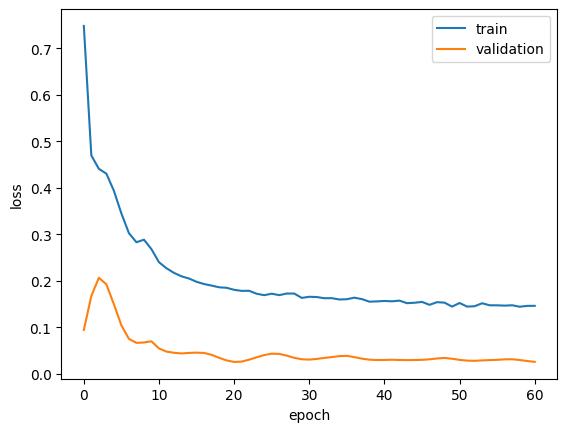

In [7]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

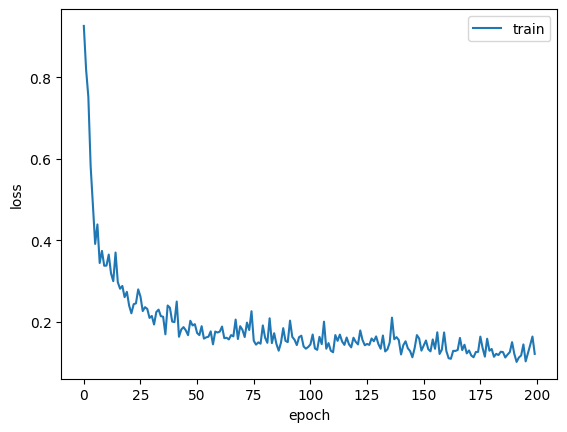

In [9]:
plt.plot(history_y.history['loss'])
# plt.plot(history_y.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [10]:
import pickle as pkl
pkl.dump(model, open("trans_findata.pkl", "wb"))
pkl.dump(model_y, open("trans_findata_y.pkl", "wb"))

In [11]:
import joblib
test_model = joblib.load("trans_findata.pkl")
test_model_y = joblib.load("trans_findata_y.pkl")
X_test_pred = test_model.predict(X_test)
y_test_pred = test_model_y.predict(y_test)

1/1 [==============================] - 1s 504ms/step


In [12]:
print(len(X_test))
print(len(X_test_pred))

89
89


In [13]:
def pred_sequence(predicted_data, predicted_data_y):
    pred_list = []
    for i in range(len(predicted_data)):
      if i == 0:
        for j in range(len(predicted_data[i])):
          pred_list.append(predicted_data[i][j])
      else:
        pred_list.append(predicted_data[i][len(predicted_data[i])-1])
    pred_list.append(predicted_data_y[len(predicted_data_y)-1][len(predicted_data_y[len(predicted_data_y)-1])-1])
    pred = np.array(pred_list)
    return pred

pred_testing_data = pd.DataFrame(pred_sequence(X_test_pred, y_test_pred), columns=testing_data.columns)
print(pred_testing_data)

     Nominal Price       Bid       Ask      High       Low  Previous Close  \
0         0.775195  0.591102  0.597055  1.036015  0.941365        0.839414   
1         0.525156  0.428640  0.524678  0.952684  0.887279        0.833850   
2         0.446874  0.303358  0.388042  0.904025  0.716121        0.965156   
3         0.906591  0.500743  0.480601  1.212618  1.064521        1.211035   
4         0.878769  0.854595  0.799776  1.011489  0.884713        0.659197   
..             ...       ...       ...       ...       ...             ...   
134       0.620121  0.519101  0.680466  1.051547  0.938373        0.932246   
135      -0.456521  1.748121  1.824364 -0.827347  0.482818       -1.612257   
136      -0.464687  1.691974  1.789289 -0.736398  0.533018       -1.495834   
137      -0.464248  1.913667  2.143172 -0.883573  0.692522       -1.524721   
138       1.019720  1.408092  1.216383  0.954912  0.790382        0.623221   

     Share Volume (000)  Turnover (000)  
0             -0.0069

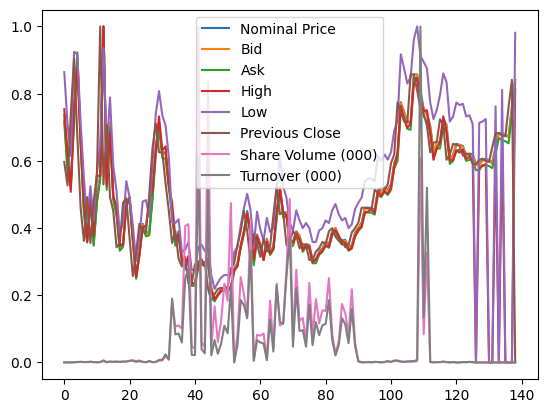

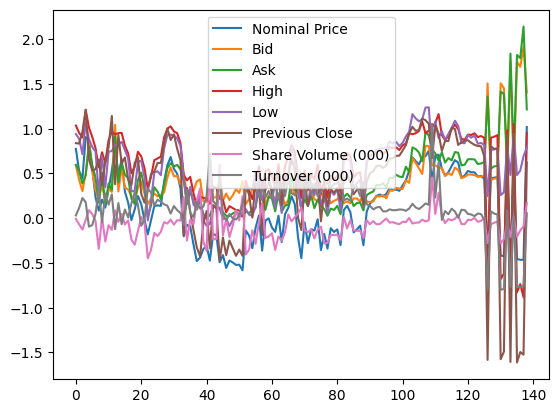

In [14]:
testing_data.plot()
pred_testing_data.plot()
plt.show()